<a href="https://colab.research.google.com/github/GunjasSingh/Pix2Pix-cGAN-Keras/blob/main/pix2pix_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Pix2Pix cGAN
a conditional Generative Adversial Network 

In [ ]:
import numpy as np
import cv2
import keras
import tensorflow as tf
import h5py

from os import listdir

from numpy import load
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randint
from numpy import vstack
from numpy import asarray
from numpy import savez_compressed

from matplotlib import pyplot as plt

from keras import Sequential
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.models import load_model
from keras.optimizers import Adam
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import ReLU

In [ ]:
def load_images(path, size=(256,512)):
    src_list, tar_list = list(), list()
    
    for filename in listdir(path):
        pixels = load_img(path + filename, target_size=size)
        pixels = img_to_array(pixels)
        s_img, t_img = pixels[:, :256], pixels[:, 256:]
        #dataset has 2 halves, the input source and the target, hence split
        src_list.append(s_img)
        tar_list.append(t_img)
        print(filename)
        
    print('Done')
    return [asarray(src_list), asarray(tar_list)]


def compress_images(src_images, tar_images, path_dest):
    print("Loaded: ", src_images.shape, tar_images.shape)
    savez_compressed(path_dest, src_images, tar_images)
    print('Compressed and saved successfully!')


def plot_figures(src_images, tar_images, plot_dest, n_samples=5):

    for i in range(n_samples):
        plt.subplot(2, n_samples, 1+i)
        plt.axis('off')
        plt.imshow(src_images[i].astype('uint8'))
    
    for i in range(n_samples):
        plt.subplot(2, n_samples, 1+n_samples+i)
        plt.axis('off')
        plt.imshow(tar_images[i].astype('uint8'))
        
    plt.savefig(plot_dest)

    print('Images saved successfully')

def convert_to_hdf5(src_images, tar_images, path_dest):
    
    print('Loaded: ', src_images.shape, tar_images.shape)

    h5f = h5py.File(path_dest, 'w')
    h5f.create_dataset('dataset_1', data=[src_images, tar_images])
    h5f.close()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path_src = "/content/drive/My Drive/Pix2Pix-cGAN-Keras/Assets/datasets/maps/train/"
path_dest = 'file.npz'
plot_dest = 'img.png'

[src_images, tar_images] = load_images(path_src)
compress_images(src_images, tar_images, path_dest)
plot_figures(src_images, tar_images, plot_dest)

Images saved successfully


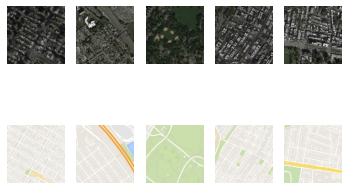

In [ ]:
plot_figures(src_images, tar_images, plot_dest)

## **Generator**

In [ ]:
def encoder(ip_layer, n_filters, batchNorm=True):
    
    
    initialized_weights = RandomNormal(stddev=0.02)
    kernel_size = (4, 4)
    stride = (2, 2)

    layer = Conv2D(n_filters, kernel_size, strides=stride, padding='same', kernel_initializer=initialized_weights)(ip_layer)

    if batchNorm:
        layer = BatchNormalization()(layer, training=True)

    layer = LeakyReLU(alpha=0.2)(layer)

    return layer

def decoder(ip_layer, skip_connection, n_filters, dropout=True):

    initialized_weights = RandomNormal(stddev=0.02)
    kernel_size = (4, 4)
    stride = (2, 2)

    layer = Conv2DTranspose(n_filters, kernel_size, strides=stride, padding='same', kernel_initializer=initialized_weights)(ip_layer)
    layer = BatchNormalization()(layer, training=True)
    
    if dropout:
        layer = Dropout(0.5)(layer, training=True)

    layer = Concatenate()([layer, skip_connection])
    layer = Activation('relu')(layer)

    return layer

def generator(image_size = (256, 256, 3)):

    kernel_init = RandomNormal(stddev = 0.02)
    ip_image = Input(shape = image_size)
    kernel_size = (4,4)
    stride = (2,2)

    e1 = encoder(ip_image, 64, batchNorm=False) # No batchNorm for first encoder layer
    e2 = encoder(e1, 128)
    e3 = encoder(e2, 256)
    e4 = encoder(e3, 512)
    e5 = encoder(e4, 512)
    e6 = encoder(e5, 512)
    e7 = encoder(e6, 512)

    # Bottleneck layer, connecting encoder and decoder
    bottle_neck = Conv2D(512, kernel_size, strides=stride, padding='same', kernel_initializer=kernel_init, activation='relu')(e7)

    d1 = decoder(bottle_neck, e7, 512)
    d2 = decoder(d1, e6, 512)
    d3 = decoder(d2, e5, 512)
    d4 = decoder(d3, e4, 512, dropout=False)
    d5 = decoder(d4, e3, 256, dropout=False)
    d6 = decoder(d5, e2, 128, dropout=False)
    d7 = decoder(d6, e1, 64, dropout=False)

    # Convolution is applied to map to the number of output channels, followed by a tanh function - Ref. 6.1.1.
    op_image = Conv2DTranspose(3, kernel_size, strides=stride, padding='same', kernel_initializer=kernel_init, activation='tanh')(d7)

    # compile model
    model = Model(ip_image, op_image)

    return model

In [ ]:
model = generator()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 128, 128, 64) 3136        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 64) 0           conv2d_22[0][0]                  
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 64, 64, 128)  131200      leaky_re_lu[0][0]                
_______________________________________________________________________________________

## **Discriminator**

In [ ]:
def discriminator(image_shape=(256, 256, 3)):

    curv_val = RandomNormal(stddev=0.02)

    src_image_inp = Input(shape=image_shape)
    target_image_inp = Input(shape=image_shape)
    merged_input = Concatenate()([src_image_inp, target_image_inp])

    kernel_size = (4,4)
    stride = (2,2)

    layer = Conv2D( 64, kernel_size, strides = stride, padding ='same', kernel_initializer=curv_val)(merged_input)
    layer = LeakyReLU(alpha=0.2)(layer)

    filter_size = [128, 256, 512]
    for i in range(len(filter_size)):
        layer = Conv2D( filter_size[i], kernel_size, strides = stride, padding ='same', kernel_initializer=curv_val)(layer)
        layer = BatchNormalization()(layer)
        layer = LeakyReLU(alpha=0.2)(layer)
        
    layer = Conv2D(512, (4,4), padding='same', kernel_initializer=curv_val)(layer)
    layer = BatchNormalization()(layer)
    layer= LeakyReLU(alpha=0.2)(layer)

    layer = Conv2D(1, (4,4), padding='same', kernel_initializer=curv_val)(layer)
    patch_out = Activation('sigmoid')(layer)

    
    model = Model([src_image_inp, target_image_inp], patch_out)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

In [ ]:
model = discriminator()
print(model.summary())

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 128, 128, 64) 6208        concatenate_7[0][0]   

## **GAN**

In [ ]:

def GAN(g_model, d_model, input_shape=(256, 256, 3)):

    ip_image = Input(shape=input_shape)

    d_model.trainable = False
    g_output = g_model(ip_image)
    d_output = d_model([ip_image, g_output])

    GAN_model = Model(ip_image, [d_output, g_output])
    loss = ['binary_crossentropy', 'mae']
    loss_weights = [1, 100]

    optimizer = Adam(lr=0.0002, beta_1=0.5, beta_2=0.999)
    GAN_model.compile(loss=loss, optimizer=optimizer, loss_weights=loss_weights)

    return GAN_model

In [ ]:
g_model = generator()
d_model = discriminator()
GAN_model = GAN(g_model, d_model)
GAN_model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
functional_5 (Functional)       (None, 256, 256, 3)  54429315    input_7[0][0]                    
__________________________________________________________________________________________________
functional_7 (Functional)       (None, 16, 16, 1)    6968257     input_7[0][0]                    
                                                                 functional_5[0][0]               
Total params: 61,397,572
Trainable params: 54,419,459
Non-trainable params: 6,978,113
__________________________________________________________________________________________________


### **Some Functions**

In [ ]:
def generate_random_training_samples(data, n_samples, n_patch):

    train_A, train_B = data
    n = randint(0, train_A.shape[0], n_samples)
    X1, X2 = train_A[n], train_B[n]
    y = ones((n_samples, n_patch, n_patch, 1))

    return [X1, X2], y

def generate_fake_samples(generator_model, samples, n_patch):
   
    print(samples.shape)
    X = generator_model.predict(samples)

    # generate the target array of zeros
    y = zeros((len(X), n_patch, n_patch, 1))
    return X, y

def load_real_samples(filename):

    data = load(filename)
    X1, X2 = data['arr_0'], data['arr_1']
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5

    return [X1, X2]

def save_model(step, g_model, d_model, gan_model, model_dest):
    filename1 = model_dest + ('model_g_%06d.h5' % (step+1))
    g_model.save(filename1)
 
    filename2 = model_dest + ('model_d_%06d.h5' % (step+1))
    d_model.save(filename2)
 
    filename3 = model_dest + ('model_gan_%06d.h5' % (step+1))
    gan_model.save(filename3)
    print('Models successfully saved at step: %d' % (step))

## **Training**

In [ ]:
def train(discriminator_model, generator_model, gan_model, data, model_dest, n_epochs=200, n_batch=1, n_patch=16, random_jitter=False, current_step=0):

    train_A, train_B = data
    batches_per_epoch = int((len(train_A)) / n_batch)
    n_steps = batches_per_epoch*n_epochs

    print(n_steps, batches_per_epoch)

    
    for i in range(current_step, n_steps):

       
        [X_real_A, X_real_B], y_real = generate_random_training_samples(data, n_batch, n_patch)

        
        if random_jitter==True:

            
            input_image = tf.image.resize(X_real_A, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
            real_image = tf.image.resize(X_real_B, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

            stacked_image = tf.stack([input_image, real_image], axis=0)

            
            cropped_image = tf.image.random_crop( stacked_image, size=[2, 1, 256, 256, 3])

            X_real_A, X_real_B = cropped_image[0], cropped_image[1]
            
            X_real_A = keras.backend.eval(X_real_A)
            X_real_B = keras.backend.eval(X_real_B)

       
        X_fake, y_fake = generate_fake_samples(generator_model, X_real_A, n_patch)

        
        discriminator_loss_real = discriminator_model.train_on_batch([X_real_A, X_real_B], y_real)
        discriminator_loss_generated = discriminator_model.train_on_batch([X_real_A, X_fake], y_fake)

        generator_loss, a, b = gan_model.train_on_batch(X_real_A, [y_real, X_real_B])

        print('%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, discriminator_loss_real, discriminator_loss_generated, generator_loss))

        # Save model state every 10 epochs
        if (i+1) % (batches_per_epoch * 10) == 0:
            save_model(i, generator_model, discriminator_model, gan_model, model_dest)

In [ ]:
def start_training(dataset_url, model_dest):

    train_generator = load_real_samples(dataset_url)
    print('Dataset Loaded', train_generator[0].shape, train_generator[1].shape)
   
    image_shape = train_generator[0].shape[1:]
 
    d_model = discriminator(image_shape)
    g_model = generator(image_shape)
  
    gan_model = GAN(g_model, d_model, image_shape)
   
    train(d_model, g_model, gan_model, train_generator, model_dest) 

def resume_training(step, dataset_url, d_model_src, g_model_src, gan_model_src, model_dest):

    d_model = load_model(d_model_src)
    g_model = load_model(g_model_src)
    gan_model = load_model(gan_model_src)

    dataset = load_real_samples(dataset_url)
    train(d_model, g_model, gan_model, dataset, model_dest, current_step=step)

In [ ]:
dataset_url = "/content/drive/My Drive/Pix2Pix-cGAN-Keras/Assets/maps.npz"
model_dest = "/content/drive/My Drive/Pix2Pix-cGAN-Keras/models/maps/"

start_training(dataset_url, model_dest)

# Call to resume training from step 153400 ( 140 epochs on the maps dataset)
step = 153440
d_model_src = model_dest + 'model_d_' + str(step) + '.h5'
g_model_src = model_dest + 'model_g_' + str(step) + '.h5'
gan_model_src = model_dest + 'model_gan_' + str(step) + '.h5'
resume_training(step, dataset_url, d_model_src, g_model_src, gan_model_src, model_dest)

Streaming output truncated to the last 5000 lines.
216701, d1[9.931] d2[3.225] g[0.932]
(1, 256, 256, 3)
216702, d1[8.691] d2[3.617] g[3.178]
(1, 256, 256, 3)
216703, d1[8.114] d2[3.393] g[2.443]
(1, 256, 256, 3)
216704, d1[6.977] d2[3.448] g[2.220]
(1, 256, 256, 3)
216705, d1[7.947] d2[3.053] g[2.456]
(1, 256, 256, 3)
216706, d1[10.948] d2[3.556] g[1.135]
(1, 256, 256, 3)
216707, d1[8.540] d2[3.407] g[2.518]
(1, 256, 256, 3)
216708, d1[8.694] d2[3.394] g[2.768]
(1, 256, 256, 3)
216709, d1[6.812] d2[3.454] g[2.115]
(1, 256, 256, 3)
216710, d1[7.617] d2[3.599] g[2.510]
(1, 256, 256, 3)
216711, d1[9.116] d2[3.277] g[1.636]
(1, 256, 256, 3)
216712, d1[9.372] d2[3.416] g[2.395]
(1, 256, 256, 3)
216713, d1[8.293] d2[3.420] g[1.356]
(1, 256, 256, 3)
216714, d1[6.994] d2[3.594] g[1.916]
(1, 256, 256, 3)
216715, d1[8.057] d2[3.550] g[3.630]
(1, 256, 256, 3)
216716, d1[8.978] d2[3.378] g[2.276]
(1, 256, 256, 3)
216717, d1[10.652] d2[3.150] g[0.509]
(1, 256, 256, 3)
216718, d1[7.271] d2[3.298] g

1227.jpg
943.jpg
2706.jpg
1794.jpg
572.jpg
200.jpg
566.jpg
2712.jpg
2289.jpg
2074.jpg
2060.jpg
1569.jpg
957.jpg
1958.jpg
1780.jpg
1757.jpg
2538.jpg
1743.jpg
228.jpg
1031.jpg
1025.jpg
2262.jpg
214.jpg
1970.jpg
2504.jpg
1964.jpg
599.jpg
1019.jpg
1192.jpg
360.jpg
412.jpg
2510.jpg
1186.jpg
1838.jpg
406.jpg
348.jpg
2276.jpg
374.jpg
1804.jpg
1810.jpg
1623.jpg
1179.jpg
2316.jpg
2470.jpg
1145.jpg
2458.jpg
2464.jpg
1384.jpg
2302.jpg
88.jpg
1151.jpg
1637.jpg
610.jpg
2855.jpg
176.jpg
2699.jpg
638.jpg
604.jpg
1390.jpg
162.jpg
1347.jpg
2869.jpg
1421.jpg
2841.jpg
2896.jpg
2128.jpg
1435.jpg
2672.jpg
2666.jpg
189.jpg
2114.jpg
1353.jpg
2882.jpg
823.jpg
1409.jpg
2100.jpg
837.jpg
77.jpg
63.jpg
980.jpg
1596.jpg
758.jpg
1233.jpg
2909.jpg
770.jpg
994.jpg
1541.jpg
2048.jpg
1555.jpg
1582.jpg
2935.jpg
2868.jpg
2854.jpg
2698.jpg
89.jpg
177.jpg
163.jpg
1391.jpg
2840.jpg
2465.jpg
1385.jpg
605.jpg
611.jpg
2303.jpg
2317.jpg
1636.jpg
1622.jpg
1144.jpg
1178.jpg
1811.jpg
1805.jpg
2459.jpg
349.jpg
2471.jpg
1150.jpg
407

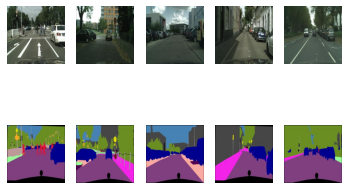

In [ ]:
path_src = "/content/drive/My Drive/Pix2Pix-cGAN-Keras/Assets/datasets/cityscapes/train/"
path_dest = 'file2.npz'
plot_dest = 'img2.png'

[src_images, tar_images] = load_images(path_src)
compress_images(src_images, tar_images, path_dest)
plot_figures(src_images, tar_images, plot_dest)

In [ ]:
dataset_url = "file2.npz"
model_dest = "/content/drive/My Drive/Pix2Pix-cGAN-Keras/models/cityscapes/"

start_training(dataset_url, model_dest)

# Call to resume training from step 153400 ( 140 epochs on the maps dataset)
step = 153440
d_model_src = model_dest + 'model_d_' + str(step) + '.h5'
g_model_src = model_dest + 'model_g_' + str(step) + '.h5'
gan_model_src = model_dest + 'model_gan_' + str(step) + '.h5'
resume_training(step, dataset_url, d_model_src, g_model_src, gan_model_src, model_dest)

Streaming output truncated to the last 5000 lines.
119362, d1[0.000] d2[0.000] g[4.221]
(1, 256, 256, 3)
119363, d1[0.000] d2[0.000] g[2.490]
(1, 256, 256, 3)
119364, d1[0.000] d2[0.000] g[3.420]
(1, 256, 256, 3)
119365, d1[0.000] d2[0.000] g[3.244]
(1, 256, 256, 3)
119366, d1[0.000] d2[0.000] g[2.046]
(1, 256, 256, 3)
119367, d1[0.000] d2[0.000] g[2.923]
(1, 256, 256, 3)
119368, d1[0.000] d2[0.000] g[3.279]
(1, 256, 256, 3)
119369, d1[0.000] d2[0.000] g[3.207]
(1, 256, 256, 3)
119370, d1[0.001] d2[0.000] g[1.864]
(1, 256, 256, 3)
119371, d1[0.000] d2[0.000] g[2.886]
(1, 256, 256, 3)
119372, d1[0.000] d2[0.000] g[5.219]
(1, 256, 256, 3)
119373, d1[0.000] d2[0.000] g[4.299]
(1, 256, 256, 3)
119374, d1[0.000] d2[0.000] g[4.090]
(1, 256, 256, 3)
119375, d1[0.000] d2[0.000] g[5.021]
(1, 256, 256, 3)
119376, d1[0.000] d2[0.000] g[3.877]
(1, 256, 256, 3)
119377, d1[0.000] d2[0.000] g[3.052]
(1, 256, 256, 3)
119378, d1[0.000] d2[0.000] g[3.927]
(1, 256, 256, 3)
119379, d1[0.000] d2[0.000] g[4

KeyboardInterrupt: ignored

In [ ]:
def plot_images(src_img, gen_img, tar_img, dest):

    # Plots all the input images in the destination specified by dest

    images = vstack((src_img, gen_img, tar_img))
    # scaling from [-1,1] to [0,1]
    images = (images + 1) / 2.0
    titles = ['Source', 'Generated', 'Expected']

    fig = plt.figure(figsize=(10, 20))

    for i in range(len(images)):
        plt.subplot(1, 3, 1 + i)
        plt.axis('off')
        plt.imshow(images[i])
        plt.title(titles[i])
    
    print('Figure saved successfully.')
    plt.savefig(dest)
 
def generate_prediction(models, dataset, dest):

    # models : input an array of models for prediction
    # dataset : path to compressed dataset (.npz format)
    # dest : destination path to store the plot

    [X1, X2] = dataset
    # selects a random image from the dataset
    ix = randint(0, len(X1), 1)

    dest = dest + 'train_' + str(ix) + '.jpg'

    # generate an image for every model
    for model in models:
        src_image, tar_image = X1[ix], X2[ix]
        gen_image = model.predict(src_image)
        plot_images(src_image, gen_image, tar_image, dest)

def prediction(model, img_url, size=(256, 512)):

    # model : accepts a model
    # img_url : input path to image
    # size : size of input image

    # load image and convert to numpy array
    pix = load_img(img_url, target_size=size)
    pix = img_to_array(pix)

    # split the image into source image and target image 
    s_img, t_img = pix[:, :256], pix[:, 256:]
    # scale from [0,255] to [-1,1]
    s = (s_img-127.5) / 127.5
    s = expand_dims(s, 0)

    # generate an image
    gen = model.predict(s)
    gen = (gen + 1) / 2
    
    # returns generated image, target image
    return gen[0], t_img

def load_and_plot(img_url, models, dest, size=(256, 512)):

    # img_url : path to image
    # models : an array of models for image generation
    # dest : destination path to save images
    # size : size of input images

    # Function used for comparison of images generated by models trained for different number of epochs

    # load and convert the image into numpy array
    pix = load_img(img_url, target_size=size)
    pix = img_to_array(pix)
    
    s_img, t_img = pix[:, :256], pix[:, 256:]
    s = (s_img-127.5) / 127.5
    s = expand_dims(s, 0)

    fig = plt.figure(figsize=(10, 20))

    for i in range(len(models)):
        
        gen = models[i].predict(s)
        gen = (gen + 1) / 2

        plt.subplot(len(models), 3, i*3 + 1)
        plt.title('Source')
        plt.axis('off')
        plt.imshow(s_img.astype('uint8'))
        
        plt.subplot(len(models), 3, i*3 + 2)
        plt.title('Generated')
        plt.imshow(gen[0])
        plt.axis('off')
        
        plt.subplot(len(models), 3, i*3 + 3)
        plt.title('Expected')
        plt.axis('off')
        plt.imshow(t_img.astype('uint8'))

    print('Figure saved successfully at destination: %s' % dest)

    plt.savefig(dest)

## **RESULTS for MAPS**

In [ ]:
#at 200 epochs
model_1 = load_model('/content/drive/My Drive/Pix2Pix-cGAN-Keras/models/maps/model_g_219200.h5', compile = False)

#at 20 epochs
model_2 = load_model('/content/drive/My Drive/Pix2Pix-cGAN-Keras/models/maps/model_g_021920.h5', compile = False)

for i in range(10):
    rando = randint(1, 1098)
    img_url = '/content/drive/My Drive/Pix2Pix-cGAN-Keras/Assets/datasets/maps/val/' + str(rando) + '.jpg'
    dest_val = '/content/drive/My Drive/Pix2Pix-cGAN-Keras/Assets/plots/maps/maps_' + str(rando) + '_generated.jpg'

    load_and_plot(img_url, models=[model_2, model_1], dest=dest_val)

#plotting only 20 epochs
for i in range(10):
    rando = randint(1, 1098)
    img_url = '/content/drive/My Drive/Pix2Pix-cGAN-Keras/Assets/datasets/maps/val/' + str(rando) + '.jpg'
    dest_val = '/content/drive/My Drive/Pix2Pix-cGAN-Keras/Assets/plots/maps/epochs_20/maps_' + str(rando) + '_generated.jpg'

    load_and_plot(img_url, models=[model_2], dest=dest_val)


#plotting only 200 epochs
for i in range(10):
    rando = randint(1, 1098)
    img_url = '/content/drive/My Drive/Pix2Pix-cGAN-Keras/Assets/datasets/maps/val/' + str(rando) + '.jpg'
    dest_val = '/content/drive/My Drive/Pix2Pix-cGAN-Keras/Assets/plots/maps/epochs_200/maps_' + str(rando) + '_generated.jpg'

    load_and_plot(img_url, models=[model_1], dest=dest_val)

Figure saved successfully.


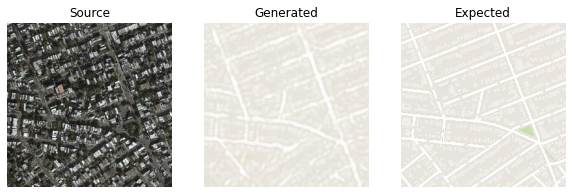

In [ ]:
dest_dir = '/content/drive/My Drive/Pix2Pix-cGAN-Keras/Assets/plots/maps/'
dataset = load_real_samples('/content/drive/My Drive/Pix2Pix-cGAN-Keras/Assets/maps.npz')
generate_prediction(models=[model_2], dataset=dataset, dest=dest_dir)

# **RESULTS FOR CITYSCAPES**

Figure saved successfully at destination: /content/drive/My Drive/Assets/plots/cityscapes/cityscapes_431_generated.jpg
Figure saved successfully at destination: /content/drive/My Drive/Assets/plots/cityscapes/cityscapes_354_generated.jpg
Figure saved successfully at destination: /content/drive/My Drive/Assets/plots/cityscapes/cityscapes_131_generated.jpg
Figure saved successfully at destination: /content/drive/My Drive/Assets/plots/cityscapes/cityscapes_348_generated.jpg
Figure saved successfully at destination: /content/drive/My Drive/Assets/plots/cityscapes/cityscapes_325_generated.jpg
Figure saved successfully at destination: /content/drive/My Drive/Assets/plots/cityscapes/cityscapes_433_generated.jpg
Figure saved successfully at destination: /content/drive/My Drive/Assets/plots/cityscapes/cityscapes_450_generated.jpg
Figure saved successfully at destination: /content/drive/My Drive/Assets/plots/cityscapes/cityscapes_103_generated.jpg
Figure saved successfully at destination: /conte

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Figure saved successfully at destination: /content/drive/My Drive/Assets/plots/cityscapes/epochs_40/cityscapes_320_generated.jpg
Figure saved successfully at destination: /content/drive/My Drive/Assets/plots/cityscapes/epochs_40/cityscapes_146_generated.jpg
Figure saved successfully at destination: /content/drive/My Drive/Assets/plots/cityscapes/epochs_40/cityscapes_387_generated.jpg
Figure saved successfully at destination: /content/drive/My Drive/Assets/plots/cityscapes/epochs_40/cityscapes_17_generated.jpg
Figure saved successfully at destination: /content/drive/My Drive/Assets/plots/cityscapes/epochs_40/cityscapes_12_generated.jpg
Figure saved successfully at destination: /content/drive/My Drive/Assets/plots/cityscapes/epochs_40/cityscapes_486_generated.jpg
Figure saved successfully at destination: /content/drive/My Drive/Assets/plots/cityscapes/epochs_40/cityscapes_134_generated.jpg
Figure saved successfully at destination: /content/drive/My Drive/Assets/plots/cityscapes/epochs_40

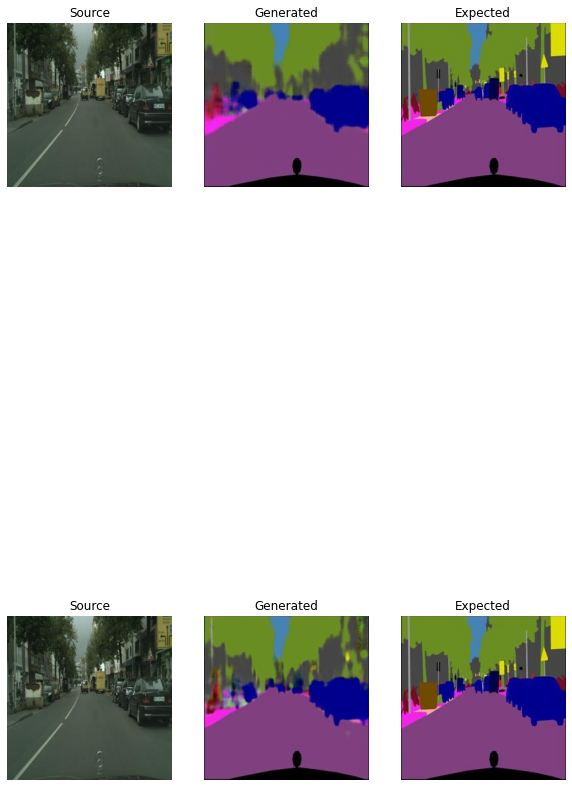

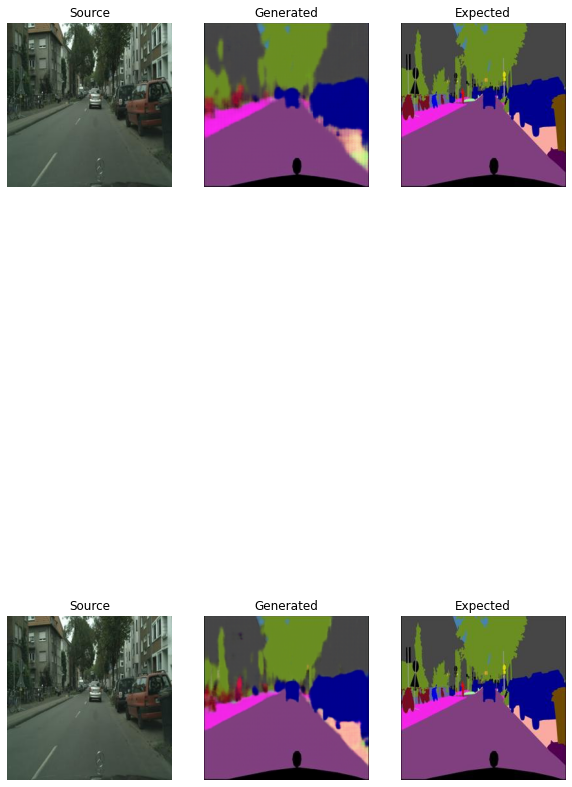

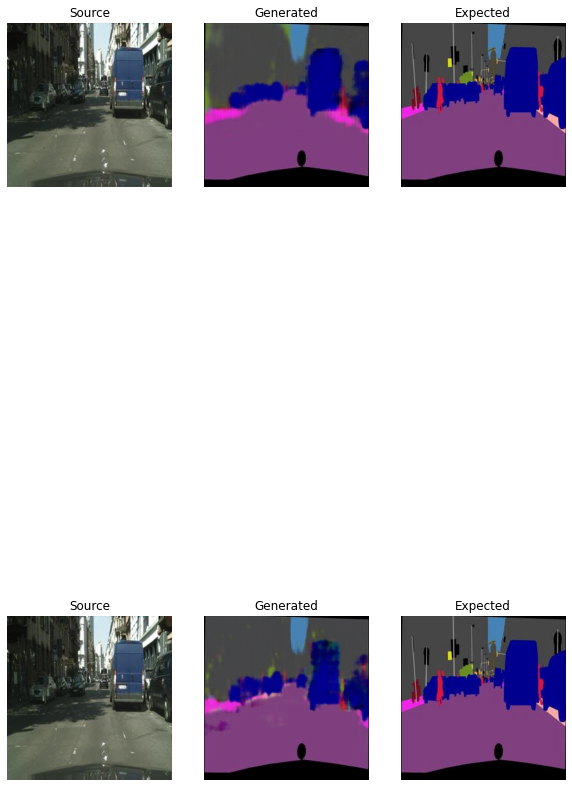

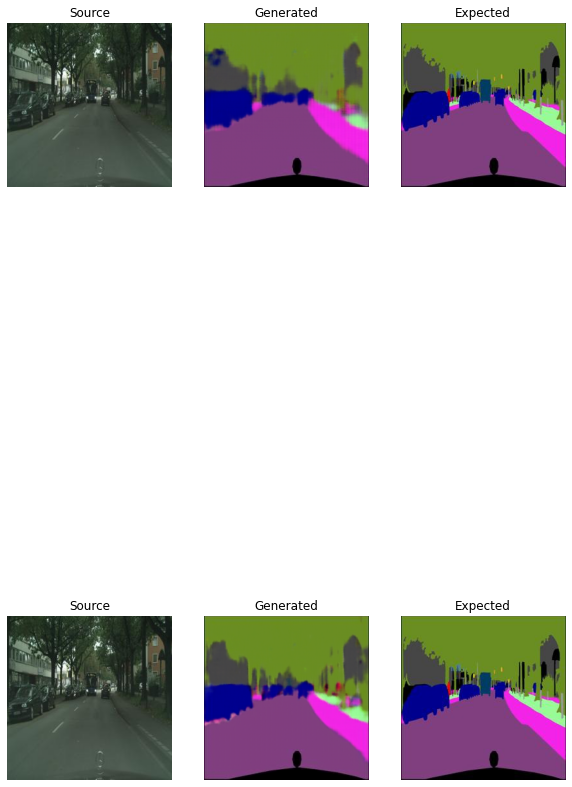

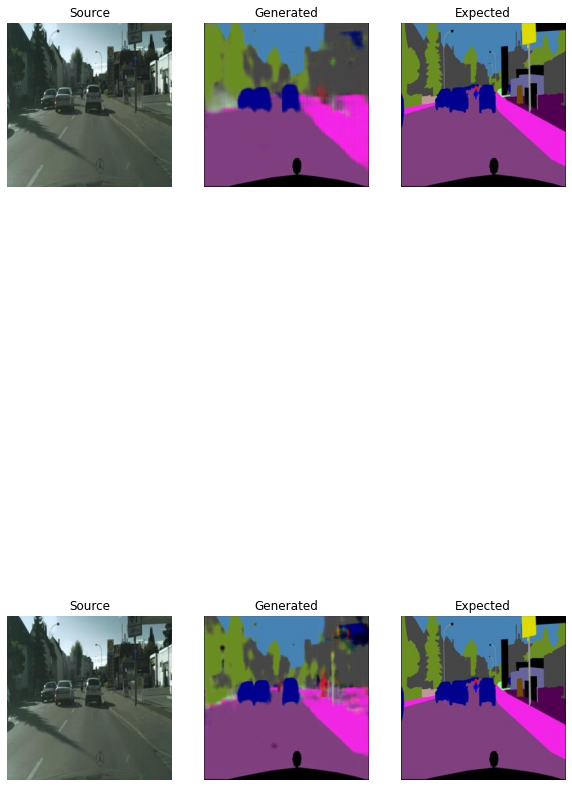

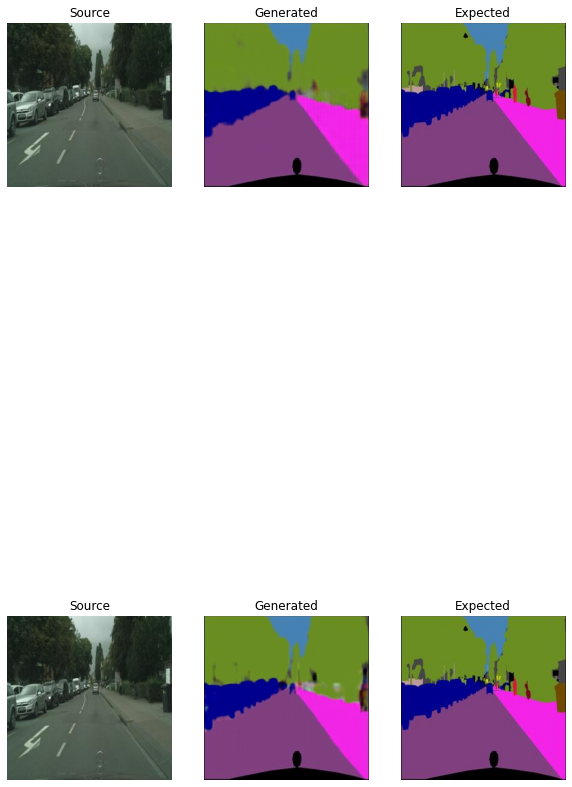

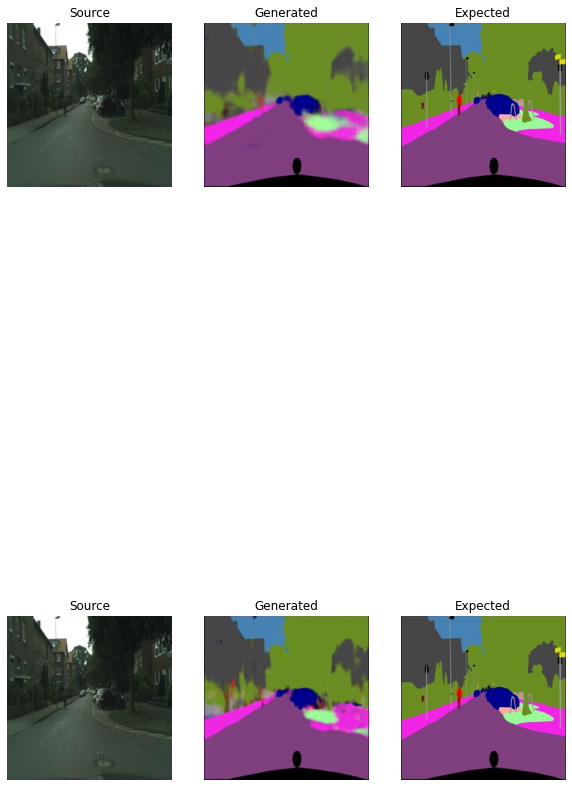

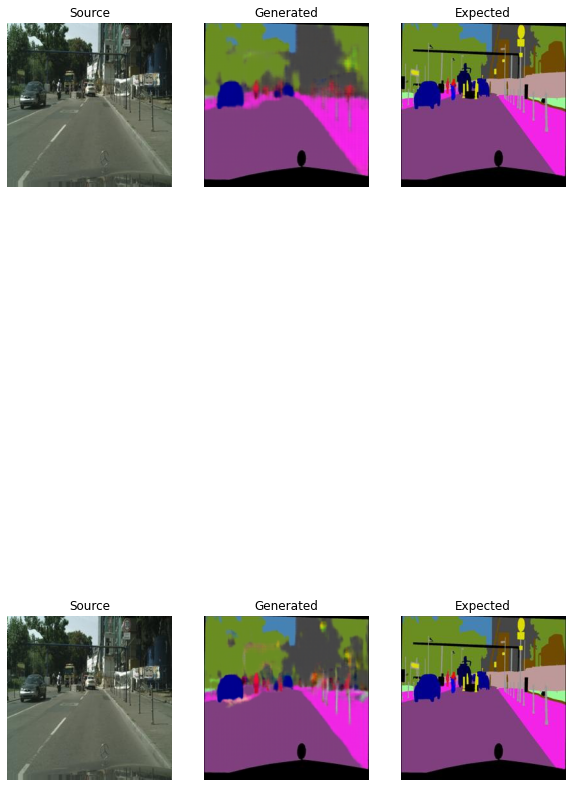

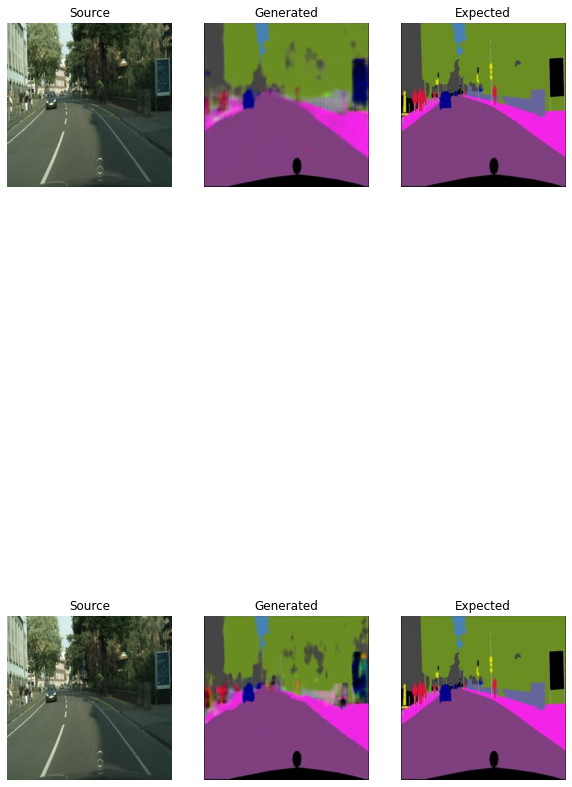

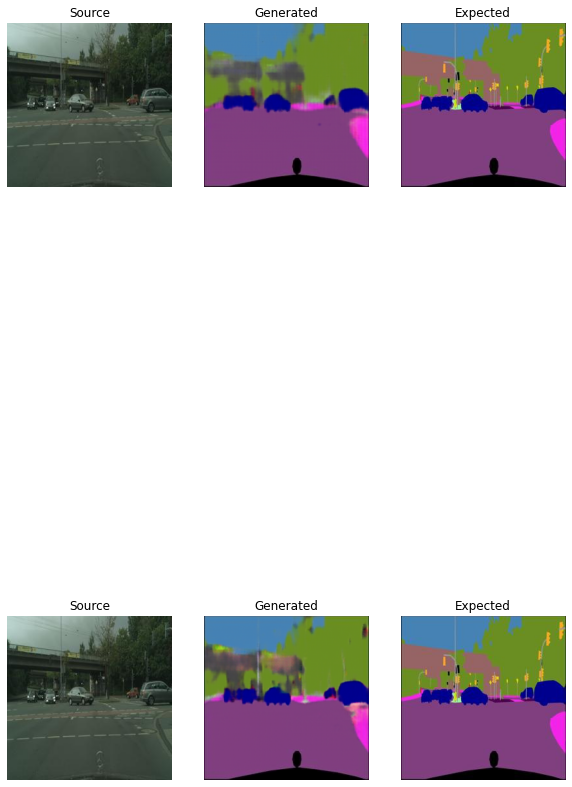

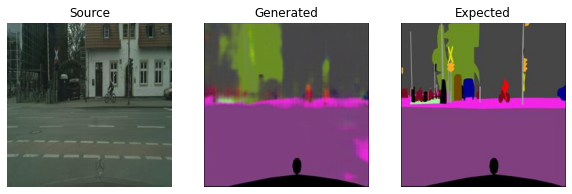

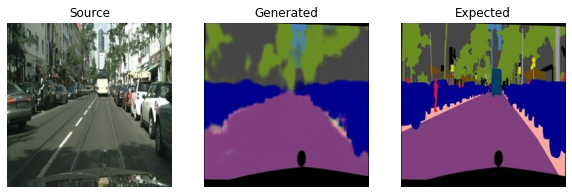

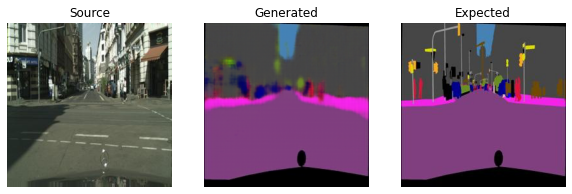

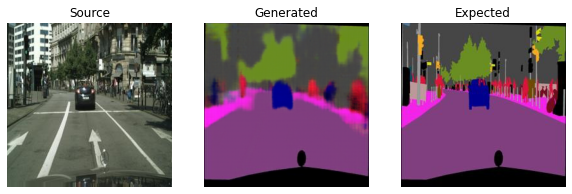

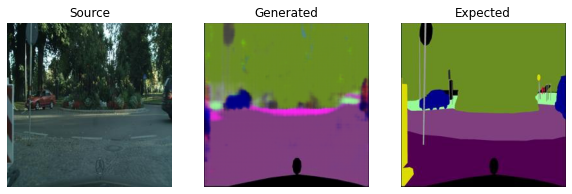

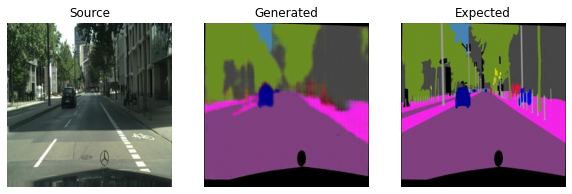

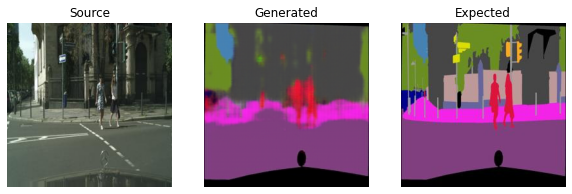

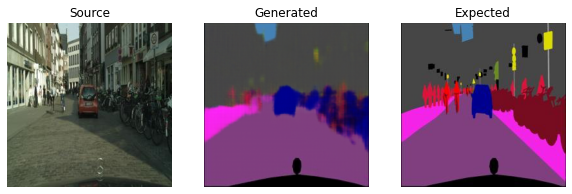

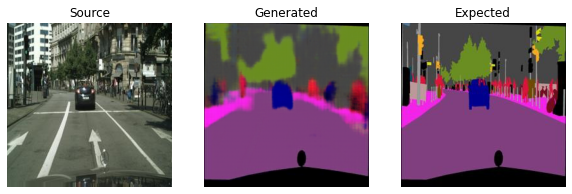

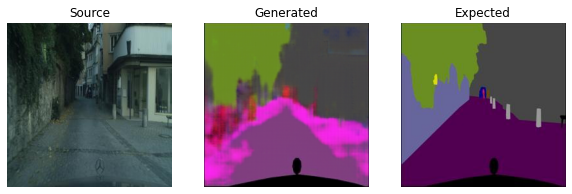

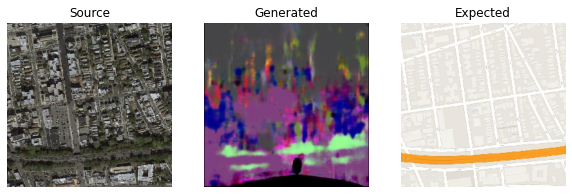

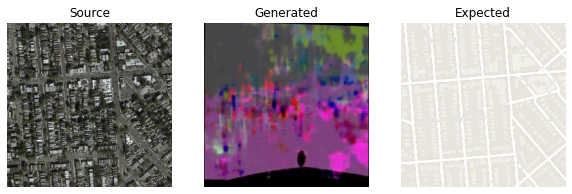

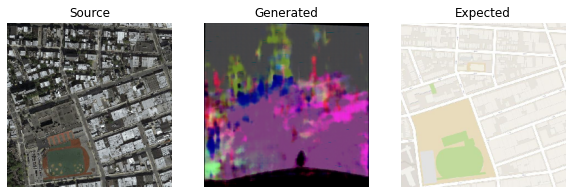

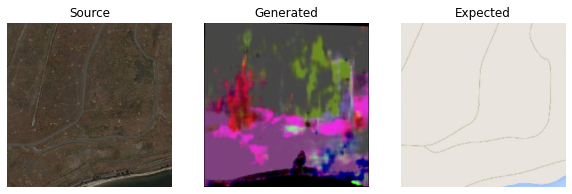

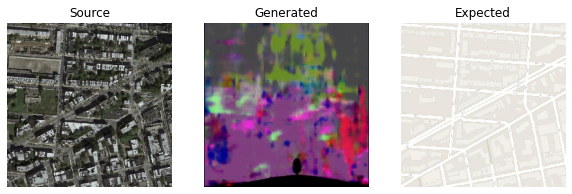

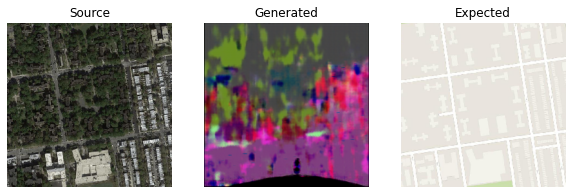

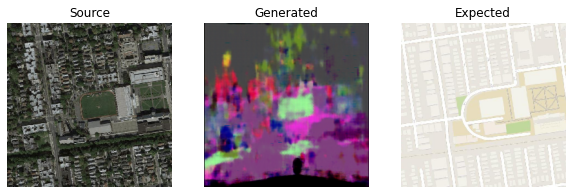

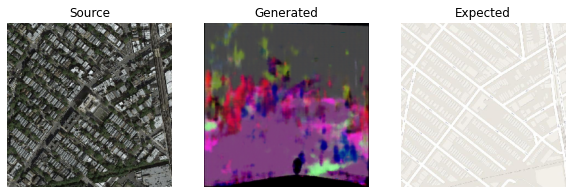

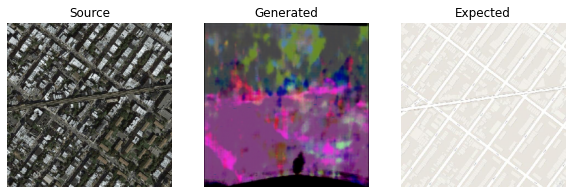

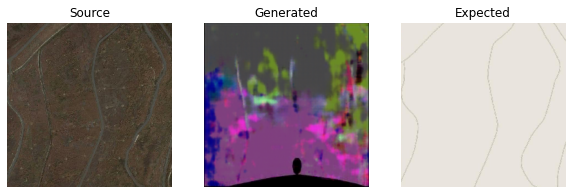

In [ ]:
#at 10 epochs
model_1 = load_model('/content/drive/My Drive/Pix2Pix-cGAN-Keras/models/cityscapes/model_g_029750.h5', compile = False)

#at 40 epochs
model_2 = load_model('/content/drive/My Drive/Pix2Pix-cGAN-Keras/models/cityscapes/model_g_119000.h5', compile = False)

for i in range(10):
    rando = randint(1, 500)
    img_url = '/content/drive/My Drive/Pix2Pix-cGAN-Keras/Assets/datasets/cityscapes/val/' + str(rando) + '.jpg'
    dest_val = '/content/drive/My Drive/Pix2Pix-cGAN-Keras/Assets/plots/cityscapes/cityscapes_' + str(rando) + '_generated.jpg'

    load_and_plot(img_url, models=[model_1, model_2], dest=dest_val)

#plotting only 10 epochs
for i in range(10):
    rando = randint(1, 500)
    img_url = '/content/drive/My Drive/Pix2Pix-cGAN-Keras/Assets/datasets/cityscapes/val/' + str(rando) + '.jpg'
    dest_val = '/content/drive/My Drive/Pix2Pix-cGAN-Keras/Assets/plots/cityscapes/epochs_10/cityscapes_' + str(rando) + '_generated.jpg'

    load_and_plot(img_url, models=[model_1], dest=dest_val)


#plotting only 40 epochs
for i in range(10):
    rando = randint(1, 500)
    img_url = '/content/drive/My Drive/Pix2Pix-cGAN-Keras/Assets/datasets/maps/val/' + str(rando) + '.jpg'
    dest_val = '/content/drive/My Drive/Pix2Pix-cGAN-Keras/Assets/plots/cityscapes/epochs_40/cityscapes_' + str(rando) + '_generated.jpg'

    load_and_plot(img_url, models=[model_2], dest=dest_val)